## Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load the data
huge_data = pd.read_csv('../data/cleaned_600k.csv')
huge_data.drop(columns=['Unnamed: 0'], inplace=True)

final_features = pd.read_csv('../data/final_features_original.csv')
final_features.drop(columns=['Unnamed: 0'], inplace=True)

program_features = pd.read_csv('../data/program_features.csv')
program_features.drop(columns=['Unnamed: 0'], inplace=True)

model = SentenceTransformer('all-MiniLM-L6-V2', device='mps')

/Users/atherv/miniforge3/envs/lifting/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# We need to normalize the features to make sure that the model doesn't get confused by the different scales of the features
scaler = StandardScaler()
final_features_scaled = pd.DataFrame(
    scaler.fit_transform(final_features),
    columns=final_features.columns,
    index=final_features.index
)

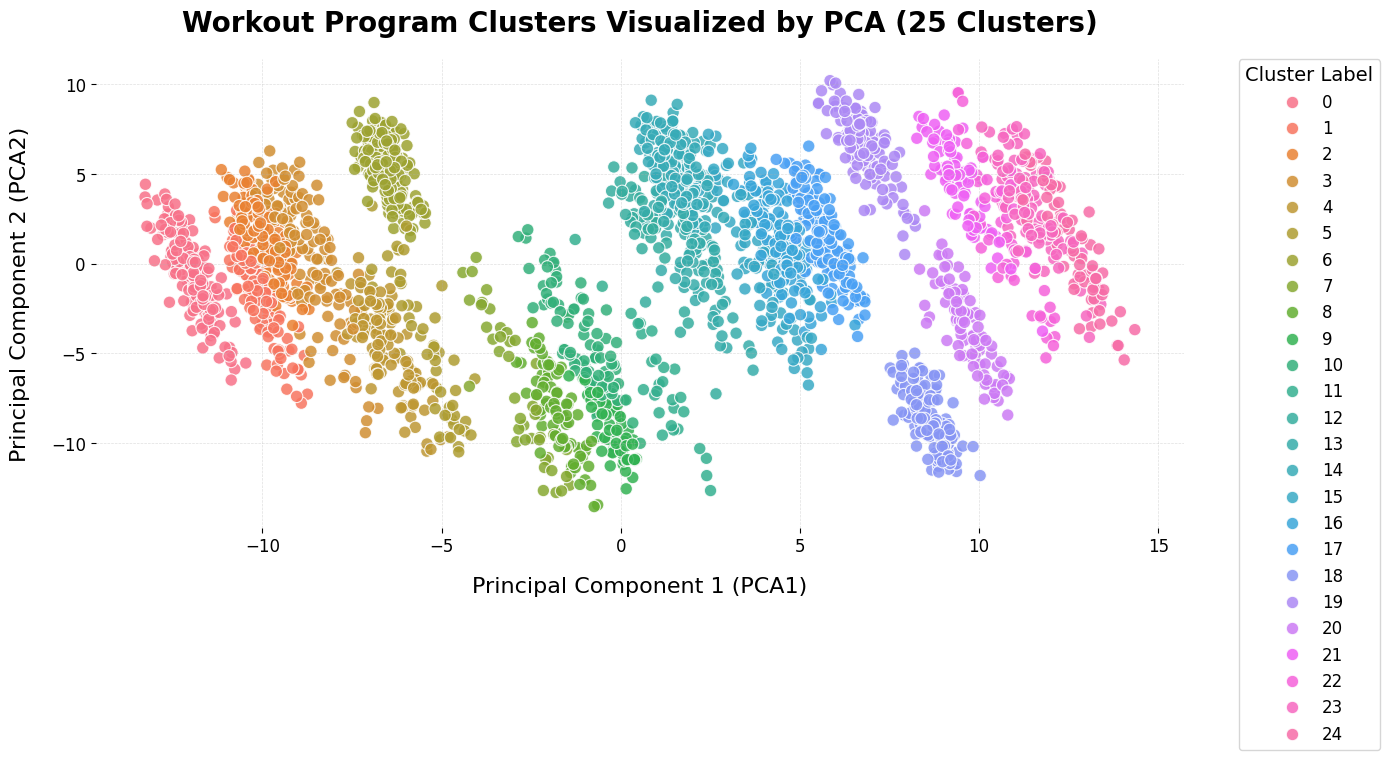

In [3]:
kmeans = KMeans(n_clusters=25, random_state=4)

clustering_data = final_features_scaled.copy()
clustering_data['cluster'] = kmeans.fit_predict(clustering_data)

pca = PCA(n_components=2, random_state=4)
reduced = pca.fit_transform(clustering_data)
clustering_data['pca1'], clustering_data['pca2'] = reduced[:, 0], reduced[:,1]

plt.figure(figsize=(14, 7))
palette = sns.color_palette("husl", n_colors=clustering_data['cluster'].nunique())

scatter = sns.scatterplot(
    data=clustering_data,
    x='pca1',
    y='pca2',
    hue='cluster',
    palette=palette,
    s=80,
    edgecolor='w',
    alpha=0.85,
    linewidth=0.8,
    legend='full'
)

plt.title('Workout Program Clusters Visualized by PCA (25 Clusters)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Principal Component 1 (PCA1)', fontsize=16, labelpad=15)
plt.ylabel('Principal Component 2 (PCA2)', fontsize=16, labelpad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Cluster Label', title_fontsize=14, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.show()

We can't see the visualize the true groupings of the data, as there are over 400 dimensions. Even so, when using PCA to reduce the dataset down to 2 dimensions, we can see some groups take shape. The embeddings that we are making along with the rest of our features are beginning to clump together.

## Model Prediction

In [4]:
similarities = cosine_similarity(clustering_data)

In [5]:
def find_top_n(similarity_matrix, n_programs, program, metadata, info, cluster=None, features=None):
    """
    Gets the top n workout programs.

    Args:
        similarity_matrix (np.ndarray): Matrix of similarity scores between programs.
        n_programs (int): Number of top similar programs to return.
        program (int): Index of the program to compare against.
        metadata (list): List of metadata column names to include in the result.
        info (list): List of info column names to include in the result.

    Returns:
        list[pd.DataFrame]: List of DataFrames, each containing the metadata and info for a top similar program.
    """
    scores = similarity_matrix[program]

    if cluster:
        mask = (features['cluster'] == cluster).values
        scores = scores * mask

    idxs = np.argsort(scores)[::-1]

    # Gets the top n indices that aren't itself
    top_n = idxs[idxs != program][:n_programs]
    top_titles = program_features['title'][top_n]

    # For each of the top n workout programs, get out only specific columns and add each DF to a list
    progs = [huge_data[huge_data['title'] == i][metadata+info] for i in top_titles]
    return progs

In [6]:
def program_recommender(program, features, similarity_matrix, model=model, n_programs=5, within_cluster=False):
    """
    Takes in a user's inputted program vector or existing program index 
    and computes the top n similar workout programs.

    Args:
        program (int or list): If int, the index of an existing program to use as the query.
                               If list, a vector of numeric features followed by a string description
                               representing a custom user program.
        features (np.ndarray): Feature matrix of all programs (used for custom queries).
        model (SentenceTransformer): Model used to encode text descriptions (default: global model).
        n_programs (int): Number of similar programs to return (default: 5).

    Returns:
        list[pd.DataFrame]: List of DataFrames, each containing metadata and info for a recommended program.
    """
    metadata = ['title', 'description', 'level', 'goal', 'equipment', 'program_length','time_per_workout', 'number_of_exercises']
    info = ['week', 'day', 'exercise_name', 'sets', 'reps', 'intensity']

    if (type(program) == int):
        return find_top_n(similarity_matrix, 
                          n_programs, 
                          program, 
                          metadata, 
                          info, 
                          features['cluster'].iloc[program] if within_cluster else None,
                          features if within_cluster else None
        )
    elif (type(program) == list):
        # Encodes the user's description for the workout
        query_embd = model.encode(program[-1])
        query_numeric = np.array(program[:-1], dtype=np.float32)
        # Concatenate the numeric features and the embedding
        query_full = np.concatenate([query_numeric, query_embd.flatten()])

        # Standardize the query
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features.drop(columns=['cluster']))
        query_full_scaled = (scaler.transform([query_full])[0].reshape(1, -1)) # Reshaping turns the query into a 2D array
        cluster = int(kmeans.predict(query_full_scaled))

        # Compute cosine similarity between the query and all existing (already scaled) features
        similarities_to_query = cosine_similarity(
            features_scaled,
            query_full_scaled 
        ).flatten()

        features_scaled = pd.concat([pd.DataFrame(features_scaled), features['cluster']], axis=1)

        return find_top_n(
            similarities_to_query.reshape(1, -1),
            n_programs,
            0,
            metadata,
            info,
            cluster if within_cluster else None,
            features_scaled if within_cluster else None
        )
    
    else:
        raise ValueError('Value inputted is not an int or NumPy array.')

In [7]:
"""
Numerical Columns:
    'reps_count': Mean reps per rep based exercise 
    'reps_time': Mean time per time based exercise ,
    'is_rep_based': Percentage of rep based exercises (0-1),
    'sets': Total number of sets per week,
    'reps_per_week': Total number of reps per week,
    'program_length': Program length (weeks),
    'time_per_workout': Workout length (minutes),
    'intensity': Average intensity level across the program (1-10),

OHE Columns:
    'level_beginner',
    'level_novice',
    'level_intermediate',
    'level_advanced',
    'goal_olympic_weightlifting', 
    'goal_muscle_&_sculpting',
    'goal_bodyweight_fitness', 
    'goal_powerbuilding', 
    'goal_bodybuilding', 
    'goal_powerlifting', 
    'goal_athletics', 
    'equipment_at home', 
    'equipment_dumbbell only', 
    'equipment_full gym', 
    'equipment_garage gym'

"""
query = [10,
        0, 
        1, 
        100, 
        400, 
        8, 
        60, 
        10, 
        1, 
        1, 
        1, 
        1, 
        0, 
        1, 
        0, 
        1, 
        1, 
        0, 
        1, 
        0, 
        0, 
        1, 
        1, 
        'Insane Arnold program, not for the weak. You need max intensity in every exercise. Push to failure ALWAYS.']

In [8]:
final_features.loc[:, 'cluster'] = clustering_data['cluster']

In [9]:
test = program_recommender(query, features=final_features, similarity_matrix=similarities, model=model, within_cluster=True)

/Users/atherv/miniforge3/envs/lifting/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/atherv/miniforge3/envs/lifting/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_26377/1124979804.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cluster = int(kmeans.predict(query_full_scaled))


In [10]:
for i in range(len(test)):
    title = test[i]['title'].iloc[0]
    description = test[i]['description'].iloc[0]
    print("="*40)
    print(f"Title: {title}\n")
    print(f"Description: {description}")
    print("="*40 + "\n")

Title: strongman

Description: Strongman
￼

Title: high frequent high intensity low volume training

Description: To Build a Foundation

Title: end of the year stronger

Description: This program will help you tone your body and maximize each work out to target all of your muscles. This is perfect if you only have 3 days a week to dedicate your work out.

Title: mike mentzer's full body routine

Description: This program is designed to build muscle through high-intensity training techniques.

The program is recommended for beginners by Mike Mentzer in his instructional video about Heavy Duty training and is designed secondarily to familiarize the beginner with the basic weightlifting movements. However, Mentzer notes that advanced trainees can benefit from this program as well.

Mentzer recommends a training strategy which is slightly unconventional. Each exercise (with few exceptions) should be taken to momentary muscular failure in all three phases of the movement: the concentric (po

While we are getting back similar-ish programs to our query, they aren't that close to the ones we want. Based on a huge dataset of user-generated data like the one we have, we would assume that our query would line up with programs that capture more of the meaning. To do this, we can fine-tune our model on our dataset. 